In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from nmf_grooming import NeuromechflyGrooming, plot_state_and_contacts

from flygym.mujoco import Parameters

# Exercise 2: Building a hierarchical controller

Here we define a new class enabling the visualization of dust on the fly's legs and antennae. When the fly is grooming, the dust will stick to the forelegs in proportion to the magnitude of the contact force. When the forelegs are touching and rubbing against each other, the amount of dust on the forelegs decreases. From a visualization point of view, the color of the legs, eyes and antenna will go from green to brown representing respectively a high and low dust level.

In [2]:
class NeuromechflyDust(NeuromechflyGrooming):
    def __init__(
        self,
        sim_params,
        init_dust_level=5.0,
        saturation_level=10.0,
        ant_decay=0.05,
        eye_decay=0.01,
        foreleg_decay=0.01,
        dusted_areas=["R_antenna", "L_antenna", "R_leg", "L_leg", "R_eye", "L_eye"],
        touch_thr=1.0,
    ):
        self.bodies_in_app = {
            "R_antenna": ["RPedicel", "RArista", "RFuniculus"],
            "L_antenna": ["LPedicel", "LArista", "LFuniculus"],
            "R_leg": [
                "RFTarsus1",
                "RFTarsus2",
                "RFTarsus3",
                "RFTarsus4",
                "RFTarsus5",
                "RFTibia",
            ],
            "L_leg": [
                "LFTarsus1",
                "LFTarsus2",
                "LFTarsus3",
                "LFTarsus4",
                "LFTarsus5",
                "LFTibia",
            ],
            "R_eye": ["REye"],
            "L_eye": ["LEye"],
        }

        self.dusted_bodies = [
            body for area in dusted_areas for body in self.bodies_in_app[area]
        ]

        self.dusted_areas = dusted_areas
        # check if the dust level is a list
        self.saturation_level = saturation_level
        if isinstance(init_dust_level, list):
            self.dust_level = np.array(init_dust_level)
        else:
            self.dust_level = np.ones(len(self.dusted_areas)) * init_dust_level
        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

        self.touch_thr = touch_thr
        self.ant_dust_decay = ant_decay
        self.eye_dust_decay = eye_decay
        self.foreleg_dust_decay = foreleg_decay

        touch_sensors_locations = []
        self.touch_sensors_ids = []
        self.appendage_touch_sensors = [[]] * len(self.dusted_areas)
        for i, area in enumerate(self.dusted_areas):
            n_touch_sensors_previous = len(touch_sensors_locations)
            if area in self.bodies_in_app:
                touch_sensors_locations += self.bodies_in_app[area]
            else:
                raise ValueError("Unknown dusted area")
            self.appendage_touch_sensors[i] = np.arange(
                n_touch_sensors_previous, len(touch_sensors_locations)
            )

        self.baseline_rgba = np.array([1.0, 1.0, 1.0, 1.0])
        self.no_dust_color = np.array([0.59, 0.39, 0.12, 1.0])
        self.full_dust_color = np.array([0.0, 1.0, 0.0, 1.0])

        super().__init__(
            sim_params=sim_params,
            groom_collision=True,
            touch_sensor_locations=touch_sensors_locations,
        )

        self.update_segment_aspect()

    def _set_geom_colors(self):
        self.areas_materials = {}
        self.areas_materials["R_leg"] = []
        self.areas_materials["L_leg"] = []

        for type_, specs in self._mujoco_config["appearance"].items():
            # If part of the dusted bodies, set the color to the baseline
            dusted_bodies_type_match = [
                db[2:-1].lower() in type_ for db in self.dusted_bodies
            ]
            if (
                "antenna" in type_
                or any(dusted_bodies_type_match)
                and not "arista" in type_
            ):
                specs["material"]["rgba"] = self.baseline_rgba
                if type_ == "eye":
                    specs["texture"] = self._mujoco_config["appearance"]["antenna"][
                        "texture"
                    ]
                    specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                    specs["texture"]["rgb2"] = self.baseline_rgba[:3]
                    specs["texture"]["width"] = 1e6
                    specs["texture"]["height"] = 1e6
                    specs["texture"]["random"] = 1e-5
                elif specs["texture"] is not None:
                    specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                    specs["texture"]["rgb2"] = self.baseline_rgba[:3]

            # Define texture and material
            if specs["texture"] is not None:
                self.model.asset.add(
                    "texture",
                    name=f"{type_}_texture",
                    builtin=specs["texture"]["builtin"],
                    mark="random",
                    width=specs["texture"]["size"],
                    height=specs["texture"]["size"],
                    random=specs["texture"]["random"],
                    rgb1=specs["texture"]["rgb1"],
                    rgb2=specs["texture"]["rgb2"],
                    markrgb=specs["texture"]["markrgb"],
                )
            self.model.asset.add(
                "material",
                name=f"{type_}_material",
                texture=f"{type_}_texture" if specs["texture"] is not None else None,
                rgba=specs["material"]["rgba"],
                specular=0.0,
                shininess=0.0,
                reflectance=0.0,
                texuniform=True,
            )
            # Apply to geoms
            for segment in specs["apply_to"]:
                geom = self.model.find("geom", segment)
                if geom is None:
                    geom = self.model.find("geom", f"{segment}")
                geom.material = f"{type_}_material"

    def get_observation(self):
        obs = super().get_observation()

        appendage_touch = [
            np.sum(obs["touch_sensors"][touch_sensors])
            for touch_sensors in self.appendage_touch_sensors
        ]

        R_antenna_contact = np.mean(
            appendage_touch[self.dusted_areas.index("R_antenna")]
        )
        L_antenna_contact = np.mean(
            appendage_touch[self.dusted_areas.index("L_antenna")]
        )
        R_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("R_leg")])
        L_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("L_leg")])
        R_eye_contact = np.mean(appendage_touch[self.dusted_areas.index("R_eye")])
        L_eye_contact = np.mean(appendage_touch[self.dusted_areas.index("L_eye")])

        is_Rantenna_grooming = (
            R_antenna_contact > self.touch_thr
            and R_leg_contact > self.touch_thr
            and L_leg_contact > self.touch_thr
        )
        is_Lantenna_grooming = (
            L_antenna_contact > self.touch_thr
            and R_leg_contact > self.touch_thr
            and L_leg_contact > self.touch_thr
        )
        is_eye_grooming = (
            R_eye_contact > self.touch_thr
            and R_leg_contact > self.touch_thr
            and L_eye_contact > self.touch_thr
            and L_leg_contact > self.touch_thr
        )

        is_foreleg_grooming = (
            R_leg_contact > self.touch_thr
            and L_leg_contact > self.touch_thr
            and not is_Rantenna_grooming
            and not is_Lantenna_grooming
            and not is_eye_grooming
        )

        self.update_dust_level(
            is_foreleg_grooming,
            is_Rantenna_grooming,
            is_Lantenna_grooming,
            is_eye_grooming,
            R_antenna_contact,
            L_antenna_contact,
            R_leg_contact,
            L_leg_contact,
            R_eye_contact,
            L_eye_contact,
        )

        self.update_segment_aspect()

        # add curr behavior
        obs["is_foreleg_grooming"] = is_foreleg_grooming
        obs["is_Rantenna_grooming"] = is_Rantenna_grooming
        obs["is_Lantenna_grooming"] = is_Lantenna_grooming
        obs["is_eye_grooming"] = is_eye_grooming

        assert all(self.dust_level >= 0.0) and all(
            self.dust_level <= self.saturation_level
        ), f"Dust level out of bounds: {self.dust_level}"
        # add dust level
        obs["dust_level"] = self.dust_level

        return obs

    def update_segment_aspect(self):
        # change body rgba depending on dust level
        for app, dl in zip(self.dusted_areas, self.dust_level):
            for body in self.bodies_in_app[app]:
                if not "Arista" in body:
                    norm_dl = (dl.copy() - 0.0) / (self.saturation_level - 0.0)
                    self.physics.named.model.geom_rgba[
                        f"Animat/{body}"
                    ] = self.interp_color(norm_dl)

    def interp_color(self, dust_level):
        return (
            self.no_dust_color
            + (self.full_dust_color - self.no_dust_color) * dust_level
        )

    def update_dust_level(
        self,
        is_foreleg_grooming,
        is_Rantenna_grooming,
        is_Lantenna_grooming,
        is_eye_grooming,
        R_antenna_contact,
        L_antenna_contact,
        R_leg_contact,
        L_leg_contact,
        R_eye_contact,
        L_eye_contact,
    ):
        is_saturated = self.dust_level >= self.saturation_level
        saturated_app = [
            self.dusted_areas[i] for i, sat in enumerate(is_saturated) if sat
        ]
        is_zero = self.dust_level <= 0.0
        zero_app = [self.dusted_areas[i] for i, zero in enumerate(is_zero) if zero]

        # update dust level bodies that have no dust should not give dust to the forelegs,
        # when the forelegs are saturated, they can not pick up dust anymore
        if is_Rantenna_grooming and not "R_antenna" in zero_app:
            removed_dust = (
                np.mean([R_antenna_contact, R_leg_contact, L_leg_contact])
                * self.ant_dust_decay
            )
            removed_dust = self.update_foreleg_dust_antgroom(
                saturated_app, removed_dust
            )
            self.dust_level[self.dusted_areas.index("R_antenna")] -= removed_dust
        if is_Lantenna_grooming and not "L_antenna" in zero_app:
            removed_dust = (
                np.mean([L_antenna_contact, R_leg_contact, L_leg_contact])
                * self.ant_dust_decay
            )
            removed_dust = self.update_foreleg_dust_antgroom(
                saturated_app, removed_dust
            )
            self.dust_level[self.dusted_areas.index("L_antenna")] -= removed_dust
        if is_eye_grooming and (not "R_eye" in zero_app or not "L_eye" in zero_app):
            removed_dust = (
                np.mean([R_eye_contact, L_eye_contact, R_leg_contact, L_leg_contact])
                * self.eye_dust_decay
            )
            if "R_eye" in zero_app:
                # if added to saturated_app no dust can be added to it
                saturated_app.append("R_leg")
            elif "L_eye" in zero_app:
                saturated_app.append("L_leg")
            removed_dust = self.update_foreleg_dust_antgroom(
                saturated_app, removed_dust
            )
            if not "R_eye" in zero_app:
                self.dust_level[self.dusted_areas.index("R_eye")] -= removed_dust
            if not "L_eye" in zero_app:
                self.dust_level[self.dusted_areas.index("L_eye")] -= removed_dust
        if is_foreleg_grooming and (not "R_leg" in zero_app or not "L_leg" in zero_app):
            removed_dust = (
                np.mean([R_leg_contact, L_leg_contact]) * self.foreleg_dust_decay
            )
            if "R_leg" in zero_app and "L_leg" in zero_app:
                removed_dust = 0
            elif "R_leg" in zero_app:
                self.dust_level[self.dusted_areas.index("L_leg")] -= removed_dust / 2
            elif "L_leg" in zero_app:
                self.dust_level[self.dusted_areas.index("R_leg")] -= removed_dust / 2
            else:
                self.dust_level[self.dusted_areas.index("R_leg")] -= removed_dust / 2
                self.dust_level[self.dusted_areas.index("L_leg")] -= removed_dust / 2

        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

    def update_foreleg_dust_antgroom(self, saturated_app, supposed_removed_dust):
        if "L_leg" in saturated_app and "R_leg" in saturated_app:
            return 0.0
        elif "R_leg" in saturated_app:
            self.dust_level[self.dusted_areas.index("R_leg")] += (
                supposed_removed_dust / 2
            )
            return supposed_removed_dust / 2
        elif "L_leg" in saturated_app:
            self.dust_level[self.dusted_areas.index("L_leg")] += (
                supposed_removed_dust / 2
            )
            return supposed_removed_dust / 2
        else:
            self.dust_level[self.dusted_areas.index("R_leg")] += (
                supposed_removed_dust / 2
            )
            self.dust_level[self.dusted_areas.index("L_leg")] += (
                supposed_removed_dust / 2
            )
            return supposed_removed_dust / 2

In [3]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep = grooming_modules["timestep"]

In [4]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    actuator_kp=10.0,
    render_camera="Animat/camera_front",
)

run_time = 1.0
target_num_steps = int(run_time / timestep)

nmf = NeuromechflyDust(
    sim_params=sim_params,
    init_dust_level=5.0,
    ant_decay=0.01,
    eye_decay=0.015,
    foreleg_decay=0.005,
)

np.random.seed(0)

obs_list = []
obs, info = nmf.reset()
obs_list.append(obs)

module_len = {
    module: len(grooming_modules[module][0])
    for module in grooming_modules
    if module != "timestep"
}

transition_period = 200
transit_to = ["L_antenna", "foreleg", "eyes", "L_antenna", "foreleg", "R_antenna"]
transit_times = [0, 1000, 3400, 4500, 6200, 7500]

k = 0

get_transition_joint_angles = lambda before, after, k: before + (after - before) * min(
    1, (k / transition_period)
)

modules = []

for i in trange(target_num_steps):
    if i in transit_times:
        k = 1
        curr_module = transit_to[transit_times.index(i)]
        print(f"Transit to {curr_module}")
        before_transition_pose = obs["joints"][0]
    else:
        k += 1

    target_joint_angles = grooming_modules[curr_module][:, k % module_len[curr_module]]
    joint_pos = get_transition_joint_angles(
        before_transition_pose, target_joint_angles, k
    )

    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    modules.append(curr_module)

    nmf.render()

modules.append(curr_module)
nmf.save_video("outputs/dust_grooming_sequence.mp4", 0)

  0%|          | 0/10000 [00:00<?, ?it/s]

Transit to L_antenna


 11%|█         | 1104/10000 [00:04<00:17, 508.79it/s]

Transit to foreleg


 35%|███▍      | 3461/10000 [00:08<00:11, 592.55it/s]

Transit to eyes


 46%|████▌     | 4590/10000 [00:12<00:19, 270.52it/s]

Transit to L_antenna


 63%|██████▎   | 6314/10000 [00:19<00:05, 631.12it/s]

Transit to foreleg


 76%|███████▌  | 7550/10000 [00:21<00:04, 566.67it/s]

Transit to R_antenna


100%|██████████| 10000/10000 [00:31<00:00, 321.68it/s]


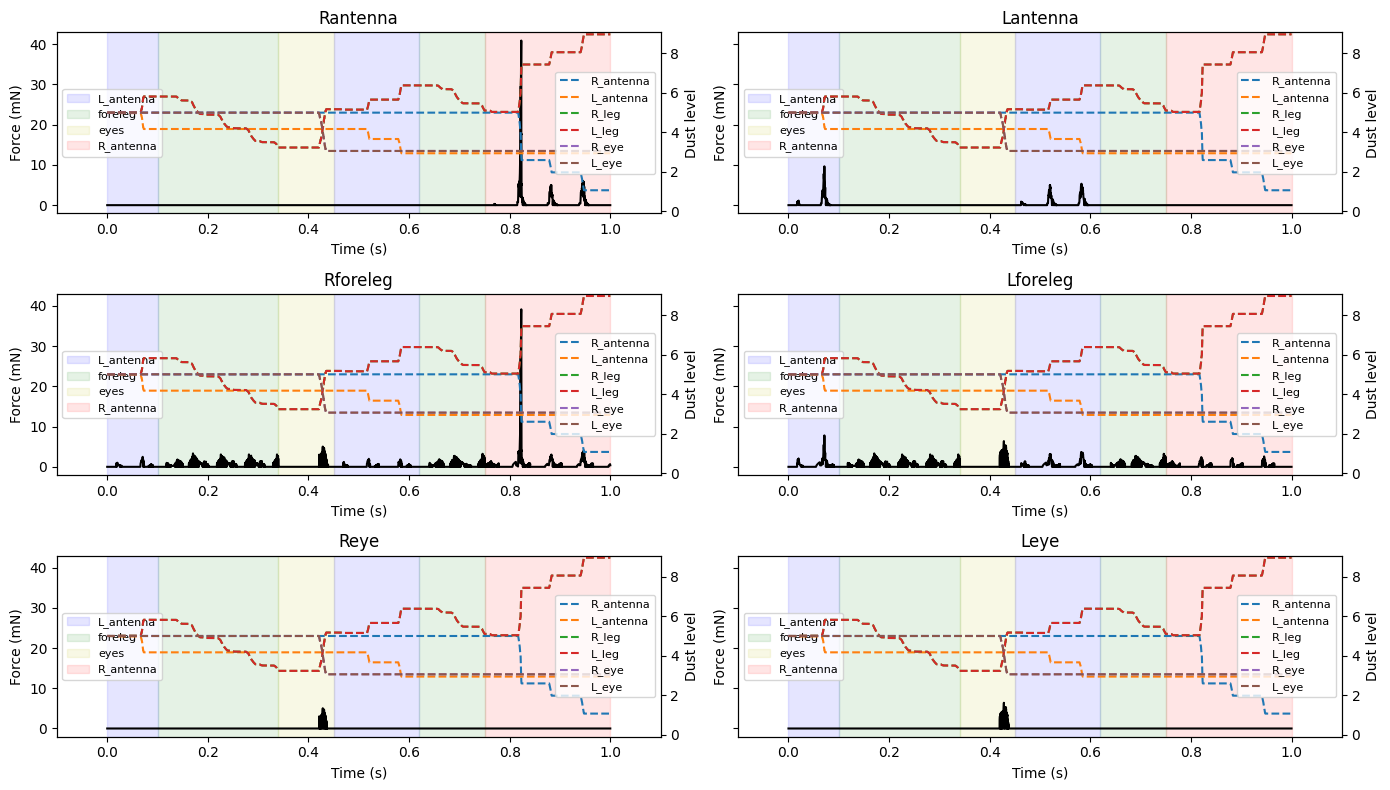

In [5]:
# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
dust_levels = np.array([obs["dust_level"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time,
    touch_sensor_data,
    nmf.touch_sensor_locations,
    transit_to,
    transit_times,
    dust_levels,
    nmf.dusted_areas,
)

# Strict hierarchy inspired by Seeds et al. (2014)

What are the states the controller can be in ?
Draw a finite state diagram representing the hierarchy described in [Seeds et al (2014)](https://elifesciences.org/articles/02951). In your diagram transition between states as well as the name of every state should be specified.

In [6]:
from abc import ABC


class DustHierarchicalController(ABC):
    def __init__(self, transition_period=200, grooming_modules=grooming_modules):
        self.grooming_modules = grooming_modules
        self.timestep = grooming_modules["timestep"]
        self.modules_names = list(grooming_modules.keys())
        self.modules_len = {
            module: len(grooming_modules[module][0])
            for module in self.modules_names
            if module != "timestep"
        }

        self.transition_period = transition_period

        self.k = 0
        self.prev_module = None
        self.before_transition_pose = None

    def select_module(self, dust_level):
        raise NotImplementedError("Implement the module selection method")

    def get_joint_angles(self, next_module, prev_pose):
        did_transit = False
        if self.prev_module is None:
            # first step
            self.prev_module = next_module
            self.k = 1
            self.before_transition_pose = prev_pose
            did_transit = True
        elif next_module != self.prev_module:
            self.prev_module = next_module
            self.before_transition_pose = prev_pose
            self.k = 1
            did_transit = True
        else:
            self.k += 1

        ja_id = self.k % self.modules_len[next_module]
        return (
            self.interp_joint_angles(
                self.grooming_modules[next_module][:, ja_id], self.k
            ),
            did_transit,
        )

    def step(self, dust_level, prev_pose):
        next_module = self.select_module(dust_level)
        return self.get_joint_angles(next_module, prev_pose)

    def interp_joint_angles(self, desired_pose, k):
        return self.before_transition_pose + (
            desired_pose - self.before_transition_pose
        ) * min(1, (k / self.transition_period))


class SeedsDHC(DustHierarchicalController):
    def __init__(
        self, dusted_areas, transition_period=200, grooming_modules=grooming_modules
    ):
        super().__init__(
            transition_period=transition_period, grooming_modules=grooming_modules
        )

        ################################################################
        # TODO: read the method section of the A. Seed et al. (2014) paper and reproduce their grooming hierarchy
        #      choose yourself whether left or right antennal grooming should be higher in the hierarchy
        # upper triangular matrix
        self.hierarchy_matrix = ...
        self.grooming_modules_hierarchy = [..., "L_antenna", "R_antenna", ...]

        self.dust_level_indexes = []
        for area in self.grooming_modules_hierarchy:
            if area == "foreleg":
                self.dust_level_indexes.append(
                    [i for i, area in enumerate(dusted_areas) if "leg" in area]
                )
            elif "antenna" in area:
                self.dust_level_indexes.append([dusted_areas.index(area)])
            elif area == "eyes":
                self.dust_level_indexes.append(
                    [dusted_areas.index("R_eye"), dusted_areas.index("L_eye")]
                )

    def select_module(self, dust_level):
        # This functon should return the next grooming module
        dust_level = [np.mean(dust_level[i]) for i in self.dust_level_indexes]
        
        ################################################################
        # HINT: Use this function to implement the hierarchical control
        activation = np.dot(dust_level, self.hierarchy_matrix)

        return self.grooming_modules_hierarchy[np.argmax(activation)]

        ################################################################

In [ ]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep = grooming_modules["timestep"]

In [7]:
run_time = 2.0
target_num_steps = int(run_time / timestep)

nmf = NeuromechflyDust(sim_params=sim_params, init_dust_level=5.0)
hc = SeedsDHC(nmf.dusted_areas)

obs_list = []
obs, info = nmf.reset()
obs_list.append(obs)

module_transit = []
module_transit_step = []

for i in trange(target_num_steps):
    joint_pos, did_transit = hc.step(obs["dust_level"], obs["joints"][0])
    if did_transit:
        module_transit.append(hc.prev_module)
        module_transit_step.append(i)

    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    nmf.render()

joint_pos, did_transit = hc.step(obs["dust_level"], obs["joints"][0])

nmf.save_video("outputs/dust_grooming_hcseeds.mp4", 0)

100%|██████████| 20000/20000 [00:53<00:00, 372.80it/s]


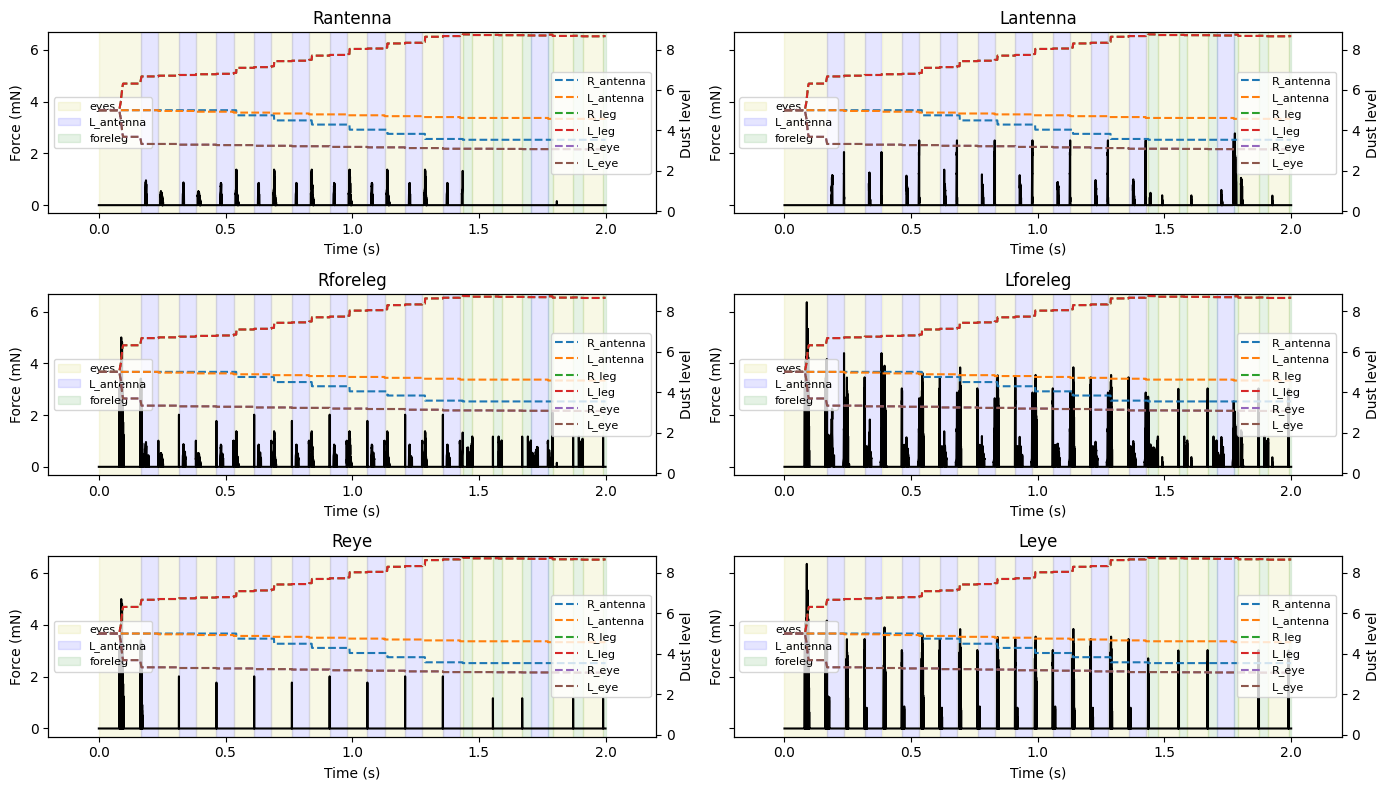

In [8]:
# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
dust_levels = np.array([obs["dust_level"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time,
    touch_sensor_data,
    nmf.touch_sensor_locations,
    module_transit,
    module_transit_step,
    dust_levels,
    nmf.dusted_areas,
)

Why is the hierarchical control stuck in a loop with only little effect on the dust level ? Look at the video and at the evolution of the dust level carefully (remember that dust removal is dependent on contacts). Compared to the replay seen in the first notebook is this grooming sequence realistic ?

Can you improve the controller and implement those changes ?

## Improved grooming control

In [9]:
################################################################
# TODO: Build a controller and a simulation that implements this more efficient grooming strategy

nmf = NeuromechflyDust(sim_params=sim_params, init_dust_level=5.0)
hc = SeedsDHC(nmf.dusted_areas)

obs_list = []
obs, info = nmf.reset()
obs_list.append(obs)

module_transit = []
module_transit_step = []

for i in trange(target_num_steps):
    if ...:
        next_module = hc.select_module(obs["dust_level"])
    joint_pos, did_transit = hc.get_joint_angles(next_module, obs["joints"][0])

    if did_transit:
        module_transit.append(hc.prev_module)
        module_transit_step.append(i)

    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    nmf.render()

joint_pos, did_transit = hc.step(obs["dust_level"], obs["joints"][0])


nmf.save_video("outputs/dust_grooming_hcpersistent.mp4", 0)

################################################################

100%|██████████| 20000/20000 [00:59<00:00, 337.85it/s]


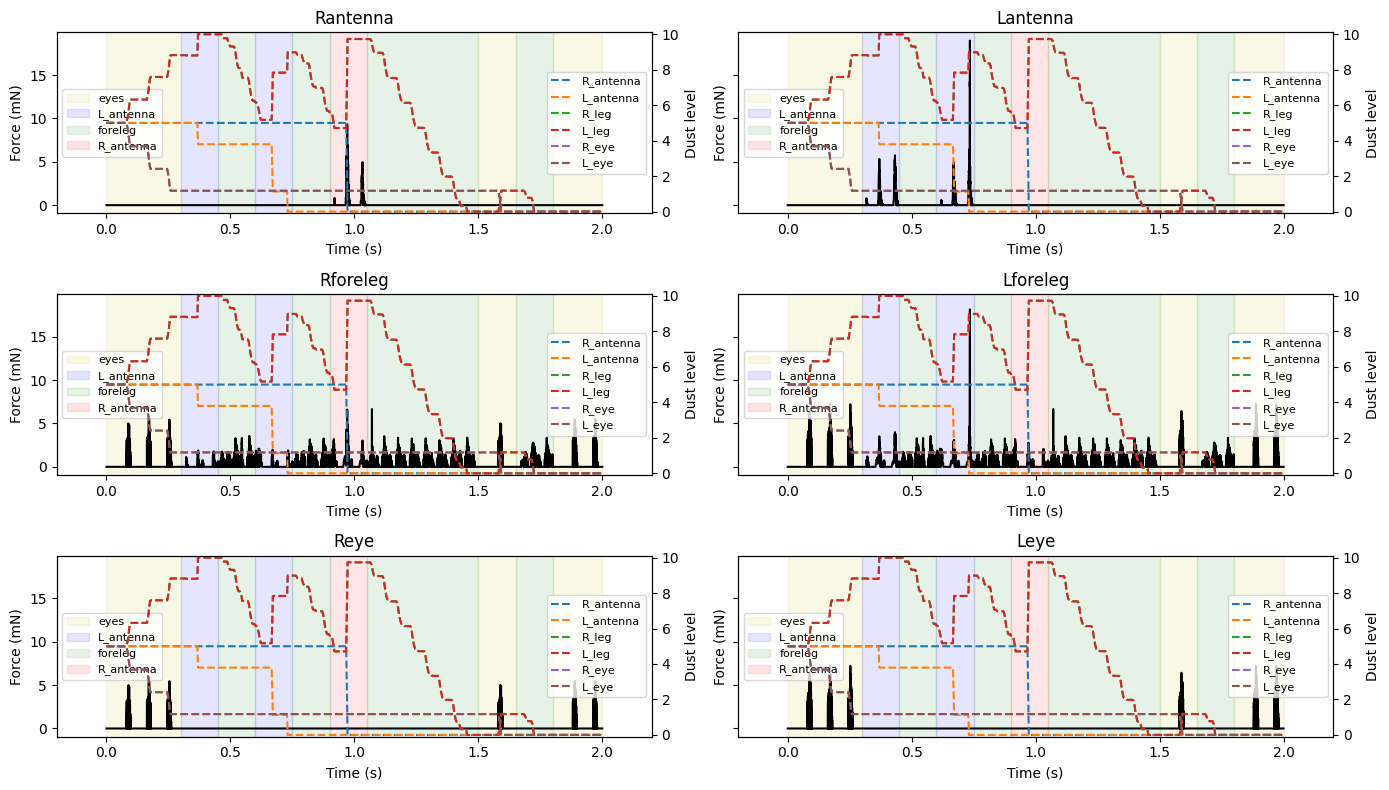

In [10]:
# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
dust_levels = np.array([obs["dust_level"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time,
    touch_sensor_data,
    nmf.touch_sensor_locations,
    module_transit,
    module_transit_step,
    dust_levels,
    nmf.dusted_areas,
)

# Test your grooming controller on a longer timescale (optional)

The plots and dynamics defined in [Seeds et al (2014)](https://elifesciences.org/articles/02951) occurs on a timescale of 30s. In our previous experiments, we boosted the amount of dust removed by a single sweep to observe changes in the grooming sequence but this approach cant not reproduce the observations made in *Drosophila*. We are going to adjust the dust removal parameters, increase the simulation timestep and run the simulation rendering to reproduce the paper's results. Note that with a bigger timestep, the contact forces and physics in general are less reliable in general.

Test the grooming controller with persistence (previous question) and compare your results to the ones obtained by [Seeds et al. (2014)](https://iiif.elifesciences.org/articles/02951).

<p align="center">
  <img src="source/seeds_et_al_2014_groomingseq.jpg" width="1200">
</p>


(Note: Running the whole simulation until the dust level is equal to zero might take up to 10 min on your computers.)



In [11]:
grooming_module_path = Path("./data/grooming_modules_provided_fast.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules_fast = pickle.load(f)

timestep = grooming_modules_fast["timestep"]

In [40]:
run_time = 20.0
target_num_steps = int(run_time / grooming_modules_fast["timestep"])

sim_params = Parameters(
    timestep=timestep, render_mode="headless", actuator_kp=10.0
)  # reduce the actuator kp to avoid physics error

nmf = NeuromechflyDust(
    sim_params=sim_params,
    init_dust_level=25.0,
    saturation_level=50.0,
    ant_decay=0.05,
    eye_decay=0.015,
    foreleg_decay=0.005,
)  # adjust the decay rates to the new contact forces
hc = SeedsDHC(
    nmf.dusted_areas, grooming_modules=grooming_modules_fast, transition_period=200
)

################################################################
# TODO: Copy paste your controller and simulation loop implementing a more persistent grooming strategy
# Make sure your controller uses the grooming_modules_fast an time periods have been adjusted to the timestep of the new grooming modules



################################################################

100%|██████████| 100000/100000 [05:07<00:00, 325.21it/s]


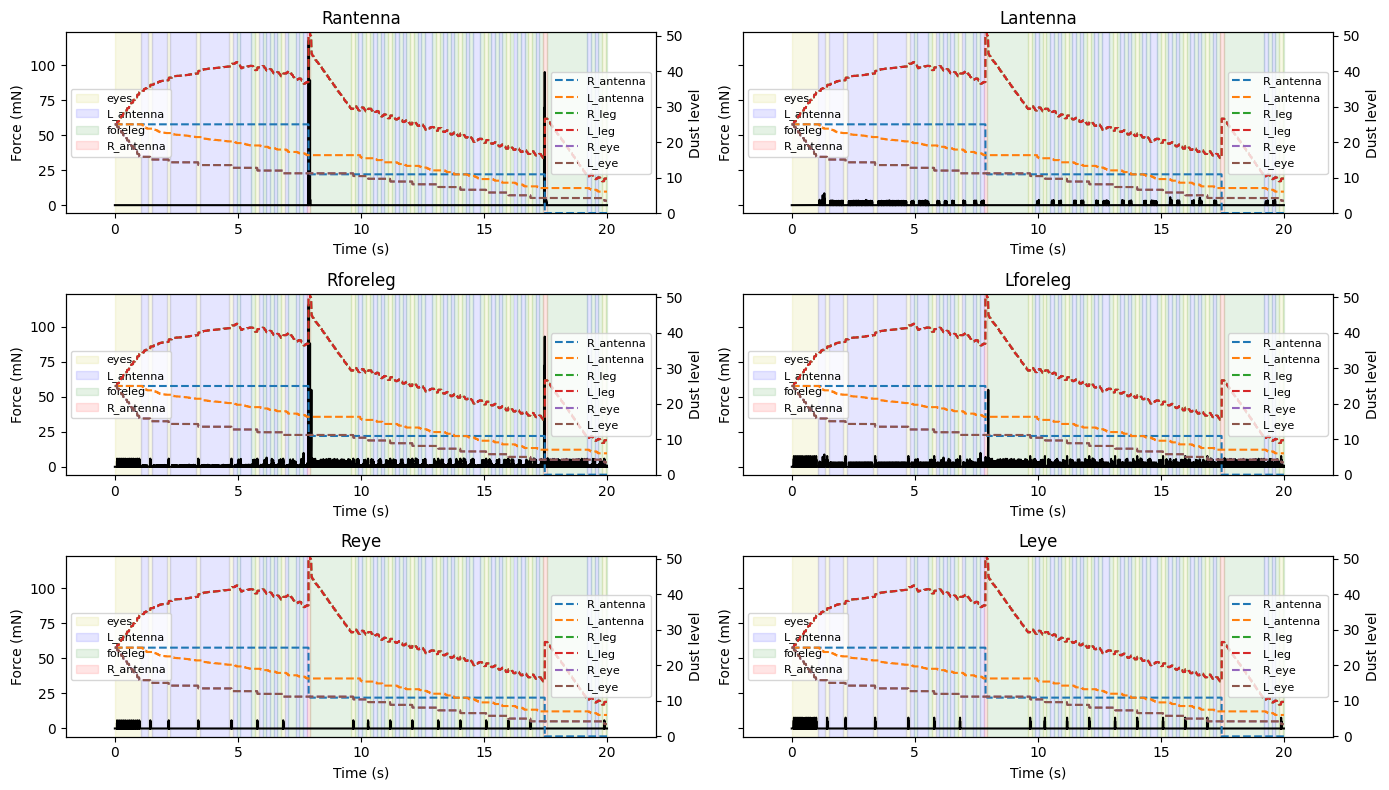

In [41]:
# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
dust_levels = np.array([obs["dust_level"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep

# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time,
    touch_sensor_data,
    nmf.touch_sensor_locations,
    module_transit,
    module_transit_step,
    dust_levels,
    nmf.dusted_areas,
)
fig.savefig("outputs/multi_grooming_touch_sensor_traces_wdust.png")

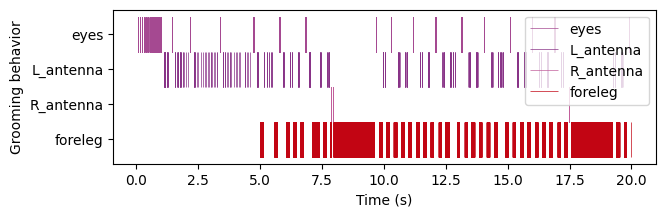

In [42]:
colors = {
    "eyes": [165, 73, 145],
    "L_antenna": [136, 51, 135],
    "R_antenna": [194, 95, 155],
    "foreleg": [194, 5, 19],
}

time = np.arange(len(obs_list)) * sim_params.timestep
modules_hierarchy = hc.grooming_modules_hierarchy

modules_times = {
    "foreleg": np.array([obs["is_foreleg_grooming"] for obs in obs_list]),
    "L_antenna": np.array([obs["is_Lantenna_grooming"] for obs in obs_list]),
    "R_antenna": np.array([obs["is_Rantenna_grooming"] for obs in obs_list]),
    "eyes": np.array([obs["is_eye_grooming"] for obs in obs_list]),
}

modules_pos = np.arange(len(modules_hierarchy))[::-1]
\
fig, ax = plt.subplots(1, 1, figsize=(7, 2))\

################################################################
# TODO: reproduce the grooming plot performed by Seeds et al. (2014) in their paper
for mn, mp in zip(modules_hierarchy, modules_pos):
    ax.vlines(...)
################################################################
    
ax.set_xlabel("Time (s)")
ax.set_ylabel("Grooming behavior")
ax.set_yticks(modules_pos)
ax.set_yticklabels(modules_hierarchy)
ax.legend()

plt.savefig("outputs/grooming_behavior_seed.png")
plt.show()
